In [1]:
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pyplot as plt
from gym.envs.registration import register
import random

C:\Users\CSH\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
register(
    id='FrozenLake-v3',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name':'4x4',
           'is_slippery':True}
)

In [3]:
env = gym.make('FrozenLake-v3')

In [4]:
env.render()


SFFF
FHFH
FFFH
HFFG


In [5]:
input_size = env.observation_space.n # 16
hidden_size = 50
output_size = env.action_space.n # 4

In [6]:
def one_hot(a):
    t=np.zeros(input_size)
    t[a]=1
    t = np.reshape(t,[1,input_size])
    return(t)

In [7]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None,input_size])
w1 = tf.get_variable(shape=[input_size, hidden_size], name='w1', initializer=tf.contrib.layers.xavier_initializer())
w2 = tf.get_variable(shape=[hidden_size, output_size], name='w2', initializer=tf.contrib.layers.xavier_initializer())
Y = tf.placeholder(tf.float32, shape=[None,output_size])

In [8]:
layer1 = tf.matmul(x,w1)
layer1 = tf.nn.tanh(layer1)
Qpred = tf.matmul(layer1,w2)
loss = tf.reduce_mean(tf.square(Y-Qpred))
train = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

In [9]:
n_episode=10000
dis = 0.9
rList=[]

In [10]:
# 이건 그냥 Q-NET이다. 다음셀에서 이걸 DQN으로 바꿔보자 
sess=tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(n_episode):
    state = env.reset()
    done = False
    e = 1/(10+i/50)
    while not done:
        Qs = sess.run(Qpred, feed_dict={x:one_hot(state)})
        action = np.argmax(Qs)
        if np.random.rand(1) <e:
            action = np.random.choice(4,1)[0] # np.array형태를 스칼라형태로바꿔주기 ! 
        new_state, reward, done, _ = env.step(action)
        if not done:
            Qs[0,action] = reward + dis* np.max(sess.run(Qpred, feed_dict={x:one_hot(new_state)}))
        else: # 이땐 무슨경우지 ?  done = True 일 경우 ! 
            Qs[0,action] = reward 
        sess.run(train, feed_dict={x:one_hot(state), Y:Qs}) # state > update 된 q값이 나오도록 network를 학습하는것!!!
        state = new_state
    rList.append(reward)
    if i%200 ==0:
        print(sess.run(loss, feed_dict={x:one_hot(state), Y:Qs}))
np.sum(rList)/n_episode
# sigmoid 씌우니까 결과 급격히 악화됨, 유투브따라서 tanh써봤더니 악화x

0.23631288
0.11821768
0.046785615
0.079661675
0.047641207
0.50802696
0.05042877
0.12135156
0.052784234
0.047504313
0.04630212
0.36476234
0.09287245
0.3877612
0.037771925
0.49866667
0.030621693
0.027073966
0.5445374
0.09429082
0.53410995
0.55840695
0.56494594
0.08044547
0.530706
0.028439498
0.07268429
0.54828715
0.55853474
0.06835953
0.02521249
0.5028451
0.4864792
0.48527318
0.06435515
0.50103635
0.46776783
0.017755225
0.015412351
0.49385113
0.05791119
0.06341727
0.022794103
0.49568653
0.48473248
0.012352165
0.5214275
0.011501666
0.011578617
0.05317287


0.4483

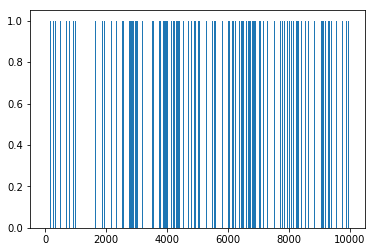

In [11]:
plt.bar(range(len(rList)), rList)
plt.show()

### Repository 

In [329]:

n_episode=10000
dis = 0.9
rList=[]

In [1]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())
repository=[] 
for i in range(n_episode):
    state = env.reset()
    done = False
    e = 1/(10+i/50)
    while not done:
        Qs = sess.run(Qpred, feed_dict={x:one_hot(state)})
        action = np.argmax(Qs)
        if np.random.rand(1) <e:
            action = np.random.choice(4,1)[0] # np.array형태를 스칼라형태로바꿔주기 ! 
        new_state, reward, done, _ = env.step(action)
        repository.append((state, action, new_state, reward, done)) # action을 빼먹엇엇다 !!!! action도 넣엇어야지
        state = new_state
        if len(repository)>50000:
            repository = repository[-50000:]
    if i%10 ==1 and len(repository)>10: # mini-batch training from repository # 아니 왜 i가 아니라 n_episode로 해놧냐 ... 
         # 여기 i로 해놓는거 맞아?  아니 에피소드 10번마다 훈련을을 한다고ㅓ ?  아 맞지맞지
        x_stack = np.empty(0).reshape(0, input_size)
        y_stack = np.empty(0).reshape(0, output_size)
        for _ in range(10):
            groups = random.sample(repository,10)
            for group in groups:
                state, action, new_state, reward, done = group
                Qs = sess.run(Qpred, feed_dict={x:one_hot(state)})
                if not done:
                    Qs[0,action] = reward + dis* np.max(sess.run(Qpred, feed_dict={x:one_hot(new_state)}))
                else:
                    Qs[0,action] = reward
                x_stack = np.vstack([x_stack, one_hot(state)]) # state를 넣으면 update된 qs값이 나오도록 network를 학습하자 ! 
                y_stack = np.vstack([y_stack, Qs])
          #      sess.run(train, feed_dict={x:one_hot(state), Y:Qs})  # 얘로 train하면 잘된다. 밑에 방법이 문제인듯.. 잉 다시 제대로되네
            sess.run(train, feed_dict={x:x_stack, Y:y_stack}) # 한방에 행렬로 넣기 # 여기서 자꾸 nan가 뜬다. 이유가뭐지
                                                              #  loss를 tf.reduce_sum말고 tf.reduce_mean 하니까 nan이 안뜬다. 
    rList.append(reward)
    
    if i%200 ==0:
        print(np.sum(rList))
np.sum(rList)/n_episode # 결과가 변동이 심하다 .. 0.01 ~ 0.2

NameError: name 'tf' is not defined

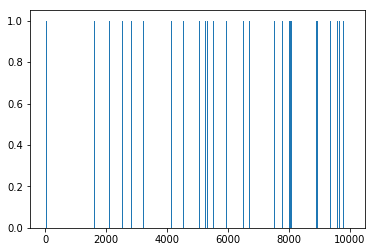

In [331]:
plt.bar(range(len(rList)), rList)
plt.show()

### Repository & separate network

In [324]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None,input_size])

 # Main DQN
with tf.variable_scope('main'):  
    w1 = tf.get_variable(shape=[input_size, hidden_size], name='w1', initializer=tf.contrib.layers.xavier_initializer())
    w2 = tf.get_variable(shape=[hidden_size, output_size], name='w2', initializer=tf.contrib.layers.xavier_initializer())
    layer1 = tf.matmul(x,w1)
    layer1 = tf.nn.tanh(layer1)
    Qpred = tf.matmul(layer1,w2)
    
 # Target DQN 
with tf.variable_scope('target'): 
    w1_1 = tf.get_variable(shape=[input_size, hidden_size], name='w1_1', initializer=tf.contrib.layers.xavier_initializer())
    w2_1 = tf.get_variable(shape=[hidden_size, output_size], name='w2_1', initializer=tf.contrib.layers.xavier_initializer())
    layer1_1= tf.matmul(x,w1_1)
    layer1_1 = tf.nn.tanh(layer1_1)
    Qpred_1 = tf.matmul(layer1_1,w2_1)

Y = tf.placeholder(tf.float32, shape=[None,output_size])
loss = tf.reduce_mean(tf.square(Y-Qpred))
train = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

main_N = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="main")
target_N = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="target")
copy=[] # 이런식의 tf 코딩이 가능함 
for main, target in zip(main_N, target_N):
    copy.append(target.assign(main.value())) # target에 main을 부여하는 과정임 

n_episode=10000
dis = 0.9
rList=[]

In [319]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(w1)

array([[-0.19819936, -0.23971161, -0.07501481, -0.23012152,  0.12849456,
        -0.2957298 ,  0.28948772,  0.15255153, -0.10780989, -0.09782837,
         0.01389894, -0.29024777, -0.1909928 , -0.11814614,  0.16845414,
        -0.15120567, -0.27569914, -0.12092718, -0.29712227,  0.2856089 ,
        -0.07302983, -0.1334917 ,  0.0849475 , -0.25970036, -0.16246036,
        -0.26280963, -0.00916135, -0.11997305,  0.285335  ,  0.1722045 ,
         0.13507262,  0.17243674, -0.16595185,  0.16143978, -0.26593983,
        -0.06062879, -0.1493378 ,  0.19160786, -0.07192947,  0.18795362,
        -0.10101551, -0.18766356,  0.287341  , -0.1007954 ,  0.01171359,
         0.11201498, -0.29051617,  0.12348986,  0.07766631,  0.24855542],
       [-0.24065827,  0.1208131 , -0.03761539,  0.10403442,  0.03976095,
        -0.06120905, -0.11006157,  0.06321985,  0.11820164, -0.00127929,
         0.26197523,  0.28680623,  0.15042809,  0.21447253,  0.1839999 ,
         0.26061088, -0.06953056,  0.0700224 , -0.

In [320]:
sess.run(w1_1)

array([[ 0.1787085 ,  0.2588297 ,  0.07961449, -0.13748057, -0.18540302,
         0.06904706,  0.06492978,  0.28249997, -0.28746614,  0.29141015,
         0.29493302,  0.16820827,  0.0587047 ,  0.14044413,  0.05458397,
         0.01369232, -0.30066663, -0.15689307,  0.1680586 , -0.115778  ,
        -0.0644583 ,  0.2263897 ,  0.26942033, -0.07813804,  0.20927835,
        -0.22425663, -0.002143  ,  0.25298256, -0.29600316,  0.06751367,
        -0.17421944, -0.27687404,  0.26039612, -0.12118749, -0.18826495,
        -0.1369704 ,  0.09465304, -0.02941707, -0.19691901, -0.13616922,
         0.2884369 , -0.02917922,  0.12443221, -0.2636103 ,  0.11402392,
        -0.11647545,  0.09164467, -0.18715581,  0.07597858, -0.1834795 ],
       [ 0.00314847,  0.02447557, -0.2590533 , -0.1199545 , -0.01705822,
        -0.19630517, -0.22230458, -0.2930905 ,  0.16594121,  0.1586282 ,
         0.10074207,  0.15395454,  0.08875114, -0.03642055, -0.0546729 ,
        -0.24880295,  0.24754387, -0.02294597,  0.

In [321]:
sess.run(copy)
sess.run(w1_1) # w1과 똑같아진다 !!! 

array([[-0.19819936, -0.23971161, -0.07501481, -0.23012152,  0.12849456,
        -0.2957298 ,  0.28948772,  0.15255153, -0.10780989, -0.09782837,
         0.01389894, -0.29024777, -0.1909928 , -0.11814614,  0.16845414,
        -0.15120567, -0.27569914, -0.12092718, -0.29712227,  0.2856089 ,
        -0.07302983, -0.1334917 ,  0.0849475 , -0.25970036, -0.16246036,
        -0.26280963, -0.00916135, -0.11997305,  0.285335  ,  0.1722045 ,
         0.13507262,  0.17243674, -0.16595185,  0.16143978, -0.26593983,
        -0.06062879, -0.1493378 ,  0.19160786, -0.07192947,  0.18795362,
        -0.10101551, -0.18766356,  0.287341  , -0.1007954 ,  0.01171359,
         0.11201498, -0.29051617,  0.12348986,  0.07766631,  0.24855542],
       [-0.24065827,  0.1208131 , -0.03761539,  0.10403442,  0.03976095,
        -0.06120905, -0.11006157,  0.06321985,  0.11820164, -0.00127929,
         0.26197523,  0.28680623,  0.15042809,  0.21447253,  0.1839999 ,
         0.26061088, -0.06953056,  0.0700224 , -0.

In [325]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())
repository=[] 
for i in range(n_episode):
    state = env.reset()
    done = False
    e = 1/(10+i/50)
    while not done:
        Qs = sess.run(Qpred, feed_dict={x:one_hot(state)}) # 여기가 main network !! 
        action = np.argmax(Qs)
        if np.random.rand(1) <e:
            action = np.random.choice(4,1)[0] # np.array형태를 스칼라형태로바꿔주기 ! 
        new_state, reward, done, _ = env.step(action)
        repository.append((state, action, new_state, reward, done)) # action을 빼먹엇엇다 !!!! action도 넣엇어야지
        state = new_state
        if len(repository)>50000:
            repository = repository[-50000:]
        if i%10 ==1 and len(repository)>10: # mini-batch training from repository # 아니 왜 i가 아니라 n_episode로 해놧냐 ... 
            x_stack = np.empty(0).reshape(0, input_size)
            y_stack = np.empty(0).reshape(0, output_size)
            for _ in range(50):
                groups = random.sample(repository,10)
                for group in groups:
                    state, action, new_state, reward, done = group 
                    Qs = sess.run(Qpred_1, feed_dict={x:one_hot(state)})
                    if not done:
                        Qs[0,action] = reward + dis* np.max(sess.run(Qpred_1, feed_dict={x:one_hot(new_state)})) # 여기 바꿧는데 
                    else:
                        Qs[0,action] = reward
                    x_stack = np.vstack([x_stack, one_hot(state)])
                    y_stack = np.vstack([y_stack, Qs])
            #        sess.run(train, feed_dict={x:one_hot(state), Y:Qs})  # 얘로 train하면 잘된다. n_episode=10000일때 0.3547
                sess.run(train, feed_dict={x:x_stack, Y:y_stack}) # 한방에 행렬로 넣기 # 여기서 자꾸 nan가 뜬다. 이유가뭐지
                                                              #  loss를 tf.reduce_sum말고 tf.reduce_mean 하니까 nan이 안뜬다. 
                                                            # 50 for문 안으로 train이 들어가야한다 이렇게하면 0.2529 
    rList.append(reward)
    
    if i % 10 ==1: # copying target N 's values and updating main Network 
        sess.run(copy)    
    
    if i%200 ==0:
        #print(sess.run(loss, feed_dict={x:one_hot(state), Y:Qs}))
        print(np.sum(rList))
np.sum(rList)/n_episode # 결과 개낮은데 10%도 안되 

0.0
0.0
1.0
9.0
20.0
34.0
45.0
65.0
76.0
93.0
105.0
121.0
145.0
181.0
219.0
252.0
285.0
327.0
352.0
394.0
433.0
478.0
512.0
556.0
595.0
632.0
667.0
693.0
735.0
767.0
812.0
853.0
886.0
908.0
938.0
969.0
1032.0
1109.0
1225.0
1335.0
1449.0
1560.0
1699.0
1816.0
1931.0
2046.0
2171.0
2263.0
2344.0
2437.0


0.2529

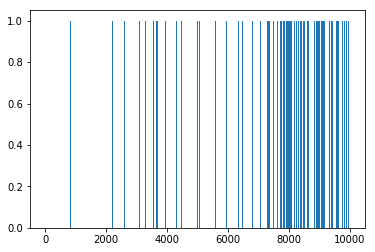

In [326]:
plt.bar(range(len(rList)), rList)
plt.show() # 학습이 되는 걸 확인할 수 있다. 